In [ ]:
!pip install sentence_transformers

In [137]:
#https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [114]:
# load data
df = pd.read_csv("data.csv")
sentences = df['text']
true_labels = df['label']
categories = [
    "produce", # fruits, vegetables 0
    "deli",     # chicken, beef, eggs 1
    "grocery",  # chips, pop, jello, baking, crackers, flour 2
    "bakery",   # cakes, breads, cookies 3
    "dairy",    # butter, milk, yoghurt 4
]

sentence_embeddings = model.encode(sentences)

In [115]:
def kNearestNeighbor(sim, k):
    sim = sim.copy()
    m,n = sim.shape
    for i in range(m):
        # only keep the k largest number
        sim[i, sim[i].argsort()[:-k]] = 0
    return sim

In [120]:
def eval_train(product_idx, method="mode"):
  """
  Use to evaluate on train dataset.

  product_idx: (int) index within train dataset
  method: (str) "mode" or "top". If mode, returns most common prediction.
          If "top", returns top prediction
  """
  # get sims
  sims = cosine_similarity(
      [sentence_embeddings[product_idx]],
      sentence_embeddings[np.arange(len(sentence_embeddings))!=product_idx]
  )
  # find 6 nearest neighbours
  nearest = kNearestNeighbor(sims, 6).tolist()[0]
  # collect indices + values
  idxs = [(i, element) for i, element in enumerate(nearest) if element]
  # sort highest to lowest
  idxs.sort(key=lambda x: x[1], reverse=True)
  # get labels from each prediction
  preds = [true_labels[i] for i, val in idxs]
  if method == "top":
    # return top prediction
    return preds[0]
  if method == "mode":
    # return common prediction
    # return mode(preds)
    return stats.mode(preds)[0][0]


In [121]:
def eval_test(product, method="mode"):
  """
  Use to evaluate on new products

  product: (str) product name
  method: (str) "mode" or "top". If mode, returns most common prediction.
          If "top", returns top prediction
  """
  # get sims
  sims = cosine_similarity(
      model.encode([product]),
      sentence_embeddings
  )
  # find 6 nearest neighbours
  nearest = kNearestNeighbor(sims, 6).tolist()[0]
  # collect indices + values
  idxs = [(i, element) for i, element in enumerate(nearest) if element]
  # sort highest to lowest
  idxs.sort(key=lambda x: x[1], reverse=True)
  # get labels from each prediction
  preds = [true_labels[i] for i, val in idxs]
  if method == "top":
    # return top prediction
    return preds[0]
  if method == "mode":
    # return common prediction
    # return mode(preds)
    return stats.mode(preds)[0][0]

In [124]:
# evaluate on training dataset
mode_predictions = []
top_predictions = []
for i in range(len(sentence_embeddings)):
  mode_predictions.append(eval_train(i))
  top_predictions.append(eval_train(i, method="top"))

In [155]:
# get accuracies
print(accuracy_score(true_labels, mode_predictions))
print(accuracy_score(true_labels, top_predictions))

0.6830985915492958
0.6713615023474179


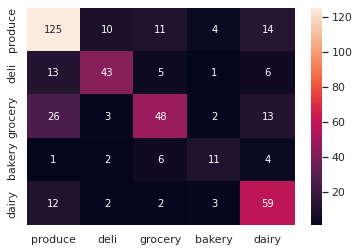

In [153]:
# confusion matrices
# conf = confusion_matrix(true_labels, mode_predictions)
conf = confusion_matrix(true_labels, top_predictions)
df_cm = pd.DataFrame(conf, categories, categories)
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g') # font size
plt.show()

In [134]:
# test new products here
product = "Western family mushrooms"
print(categories[eval_test(product, method="top")])

produce
